# **Glove**
* 미국 스탠포드대학에서 2014년 개발한 워드 임베딩 방법론
* 기존의 word2vec과 LSA의 단점을 보완하기 위해 나옴

Word2vec의 단점
* 단어의 유사도를 측정하기는 좋지만 사용자가 지정한 윈도우 내에서만 학습/분석이 이뤄지기 때문에 말뭉치 전체의 co-occurrence는 반영되기 어려움

LSA의 단점
* 말뭉치 전체의 통계 정보는 이용하지만 단어/문서 간 유사도 측정이 어려움

Glove의 목적 함수
* 임베딩 된 두 단어벡터의 내적이 말뭉치 전체에서의 동시 등장확률 로그값이 되도록 설정 함
* 임베딩 된 단어 벡터 간 유사도 측정을 수월하게 하면서도 말뭉치 전체의 통계 정보를 더 잘 반영할 수 있음
* 학습 말뭉치를 대상으로 symmetric한 행렬 X를 만들고 아래 목적함수를 최소화 할 수 있는 matrix factorization을 수행
* 지나치게 빈도가 높은 단어 때문에 목적함수 값이 튀는 것을 방지하기 위해 Xmax 이상인 경우에는 f(Xij)값이 1로 수렴하게 설정

## **Keras에서 pre-trained된 Glove 모델 사용하기**

keras에서 text data를 사용하기 위해서는 text를 컴퓨터가 이해할 수 있는 숫자 데이터로 바꿔줘야 한다. 이를 위해 keras에서는 tokenizer API를 제공한다.

* Tokenizer.fit_on_texts : 입력에 맞게 내부의 word_index를 생성
* Tokenizer.texts_to_sequences : 문장을 index의 sequence로 변환
* pad_sequences : 길이가 각기 다른 문장을 maxlen에 따라 동등하게 맞춰줌

In [2]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

# 하이퍼 파라미터 설정
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2021-01-18 13:59:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  87.3MB/s    in 2.6s    

2021-01-18 13:59:19 (87.3 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [4]:
num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        # 1. list_item 에 문장과 라벨을 넣는다
        list_item=[]
        list_item.append(row[5]) # 문장
        this_label=row[0] # 긍정 or 부정
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        # 2. corpus에 lis_item을 한 덩어리로 넣는다 (2차원 리스트가 됨)
        corpus.append(list_item)

In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1]) # 문장과 라벨이 한쌍으로

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [26]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
  # 문장과 라벨 셋 분리
  sentences.append(corpus[x][0]) # 문장
  labels.append(corpus[x][1]) # 라벨
print(sentences[0])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# integer encode the documents
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences[0])

# pad documents to a max length of 16 words
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(padded[0])


Change of plan, im not in work today 
[586, 12, 773, 59, 24, 11, 46, 40]
[586  12 773  59  24  11  46  40   0   0   0   0   0   0   0   0]


In [15]:
# train, test split
split = int(test_portion * training_size)

test_sequences = padded[0:split] # 16000
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

train_dataset = tf.data.Dataset.from_tensor_slices((training_sequences, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))

In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

In [27]:
print(vocab_size)
print(word_index['i'])

139025
1


In [11]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};

--2021-01-18 14:01:30--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  78.4MB/s    in 4.2s    

2021-01-18 14:01:35 (78.4 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



pre-trained된 glove.6B.100d 파일은 각 줄마다 101개의 값이 존재함
1개는 word, 100개는 word에 대한 vector 값 (100차원)
이를 단어 / 벡터값으로 python dict 타입으로 읽어옴

In [29]:
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
# 단어의 index 부분에 해당 vector 값을 꺼내어 넣어주는 부분
embeddings_matrix = np.zeros((vocab_size, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

Loaded 400000 word vectors.


In [13]:
print(len(embeddings_matrix))

138764


* vocab_size, dimension(100) 명시
* input_length는 최대 문장 길이가 16이기 때문에 16으로 설정
* trainable false인 경우에는 pre-trained된 vector값이 변하지 않음

In [18]:
# 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           13876400  
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 13,941,553
Trainable params: 65,153
Non-trainable params: 13,876,400
_____________________________________

In [23]:
num_epochs = 5
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, verbose=2)

print("Training Complete")

Epoch 1/5
2250/2250 - 18s - loss: 0.4984 - acc: 0.7532 - val_loss: 0.4976 - val_acc: 0.7561
Epoch 2/5
2250/2250 - 18s - loss: 0.4900 - acc: 0.7583 - val_loss: 0.4923 - val_acc: 0.7557
Epoch 3/5
2250/2250 - 18s - loss: 0.4845 - acc: 0.7620 - val_loss: 0.4940 - val_acc: 0.7588
Epoch 4/5
2250/2250 - 18s - loss: 0.4799 - acc: 0.7650 - val_loss: 0.4924 - val_acc: 0.7601
Epoch 5/5
2250/2250 - 18s - loss: 0.4751 - acc: 0.7683 - val_loss: 0.4939 - val_acc: 0.7564
Training Complete


<Figure size 432x288 with 0 Axes>

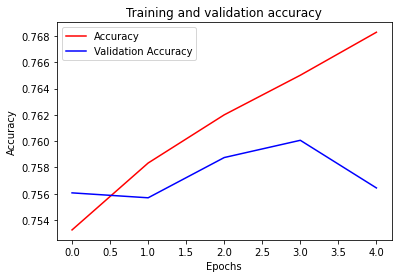

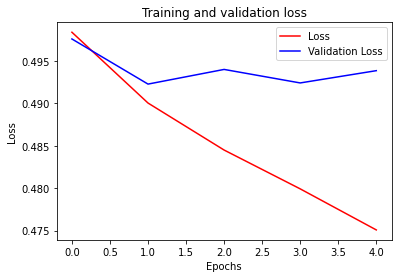

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!